In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
fedavg_df = pd.read_csv("./analiza/200/size_2024-08-31_15-29-48.csv")  # fedavg
fedprox_df = pd.read_csv("./analiza/200/size_2024-08-31_16-09-48.csv")  # fedprox

# Display the first few rows of the data
print(fedavg_df.head())

                  object_name      size
0               WRITE:model:1  89487235
1           WRITE:iteration:1        38
2    WRITE:algorithm_params:1       190
3  WRITE:model_train_params:1       241
4   WRITE:model_eval_params:1       116


In [2]:
def parse_row(row):
    operation, key, iteration = row["object_name"].split(":")
    row["operation"] = operation
    row["key"] = key
    row["iteration"] = iteration

    return row


def add_data(df):
    return df.apply(parse_row, axis=1)

In [3]:
def sum_by_operation(df):
    return df.groupby("operation").sum()


def sum_by_key(df):
    return df.groupby("key").sum()


def sum_by_op_key(df):
    return df.groupby("operation", "key").sum()

In [34]:
def correct_dataset_size(df):
    df = add_data(df)
    df.loc[df["key"] == "user_dataset", "size"] *= 100
    df.loc[df["operation"] == "WRITE", "operation"] = "Size (MB)"
    return df


fedavg_df_new = correct_dataset_size(fedavg_df)
fedprox_df_new = correct_dataset_size(fedprox_df)

In [32]:
fedavg_df_new.head()

,object_name,size,operation,key,iteration
0,WRITE:model:1,89487235,SIZE,model,1
1,WRITE:iteration:1,38,SIZE,iteration,1
2,WRITE:algorithm_params:1,190,SIZE,algorithm_params,1
3,WRITE:model_train_params:1,241,SIZE,model_train_params,1
4,WRITE:model_eval_params:1,116,SIZE,model_eval_params,1


/tmp/ipykernel_12357/3799888914.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(x="key", y="size", data=df_filtered, ax=ax, ci=None)
/tmp/ipykernel_12357/3799888914.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.barplot(x="key", y="size", data=df_filtered, ax=ax, ci=None)


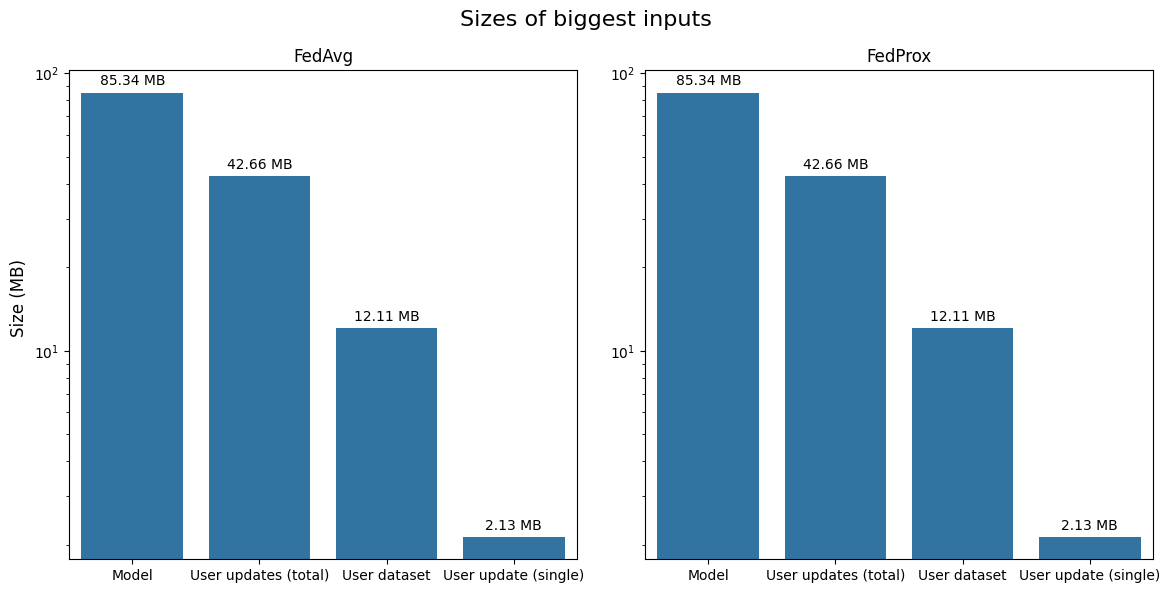

In [69]:
label_mapping = {
    "model": "Model",
    "stats_context_pairs": "User updates (total)",
    "user_dataset": "User dataset",
    "user_metrics": "User update (single)",
}


def plot_2(df, ax, title):
    # convert size to MB
    df = df.copy()
    df["size"] /= 1024 * 1024

    df = df[~df["key"].isin(["server_statistics"])]
    stats_context_pairs_size = df[df["key"] == "stats_context_pairs"]["size"].mean()
    extra_bar_size = stats_context_pairs_size / 20
    # Group by 'key' and sum the 'size' for each key
    grouped = df.groupby("key")["size"].sum().reset_index()
    xd = pd.DataFrame({"key": [label_mapping["user_metrics"]], "size": [extra_bar_size]})
    grouped = pd.concat([grouped, xd], ignore_index=True)

    # Sort by size and select top 5
    top_5_keys = grouped.nlargest(4, "size")["key"].tolist()

    # Filter the original dataframe to include only the top 5 keys
    df_filtered = df[df["key"].isin(top_5_keys)]
    df_filtered = pd.concat([df_filtered, xd], ignore_index=True)
    df_filtered["key"] = df_filtered["key"].map(label_mapping).fillna(df_filtered["key"])
    key_totals = df_filtered.groupby("key")["size"].mean().reset_index()
    sorted_keys = key_totals.sort_values("size", ascending=False)["key"].tolist()
    df_filtered["key"] = pd.Categorical(df_filtered["key"], categories=sorted_keys, ordered=True)

    # Create the plot

    plot = sns.barplot(x="key", y="size", data=df_filtered, ax=ax, ci=None)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # Customize the plot

    ax.set_yscale("log")

    for container in plot.containers:
        ax.bar_label(container, fmt="%.2f MB", padding=3)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Sizes of biggest inputs", fontsize=16)
fig.supylabel("Size (MB)", fontsize=12)
# Usage
plot_2(fedavg_df_new, ax[0], "FedAvg")
plot_2(fedprox_df_new, ax[1], "FedProx")

# Show the plot
fig.tight_layout()
plt.show()